In [1]:
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# !pip install pandas
# !pip install tqdm
# !pip install matplotlib
# !pip install opencv-python
# !pip install scikit-learn
# !pip install seaborn

In [2]:
# Required Libraries
import os
import random
import shutil
import torch
from collections import defaultdict
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# ResEmoteNet

The code below was adopted from the ResEmoteNet repository outlined below and altered to facilitate integration with the five datasets.

**LINK**: https://github.com/ArnabKumarRoy02/ResEmoteNet

In [3]:
# Dataset class for the custom dataset
class Four4All(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

## ResEmoteNet Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    
class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)
        
        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 7)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

## ResEmoteNet Training

In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def TrainResEmoteNet(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs, checkpoint=None):
    # Transform the dataset
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Load the dataset
    train_dataset = Four4All(csv_file=data_directory+'/train/labels.csv',
                            img_dir=data_directory+'/train', transform=transform)

    val_dataset = Four4All(csv_file=data_directory+'/validation/labels.csv', 
                        img_dir=data_directory+'/validation/', transform=transform)

    num_classes = train_dataset.labels.iloc[:, 1].nunique()
    print(f"Number of classes: {num_classes}")

    # Calculate class weights for the training dataset (balanced weights) - Modification
    labels = train_dataset.labels.iloc[:, 1].values
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    
    # Load the dataset with the current batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Reinitialise the model
    model = ResEmoteNet().to(device)
    model.fc4 = nn.Linear(256, num_classes).to(device)

    if checkpoint is not None:
        model.load_state_dict(torch.load(checkpoint))
    
    # Hyperparameters
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Apply class weights here - Modification
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Training parameters
    patience_counter = 0
    best_val_acc = 0

    # Start training
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation evaluation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            os.makedirs("Models", exist_ok=True)
            print(f"Saving model with best validation accuracy: {best_val_acc}")
            torch.save(model.state_dict(), f'Models/ResEmoteNet_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy for {patience_counter} epochs.")
        
        if patience_counter > patience:
            print("Stopping early due to lack of improvement in validation accuracy.")
            break

    print(f"Finished training with lr={lr}, batch_size={batch_size}, momentum={momentum}, weight_decay={weight_decay}")
    print(f"Best validation accuracy: {best_val_acc}\n")

### Training the Model

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/AffectNet_Structured_Aligned' # 51% Acc on Test Set 0.001 16 0.9 1e-4 15 300
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured_Aligned'
# dataset_name, data_directory = 'FER_Aligned', '../../Datasets/FER_Structured_Aligned' # 63% Acc on Test Set 0.001 16 0.9 1e-4 15 300 | 81 epochs | 109minutes
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured_Aligned'
# dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/RAF-DB_Structured_Aligned' # 78% Acc on Test Set 0.001 16 0.9 1e-4 15 300 | 76 epochs | 50minutes

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300

# Checkpoint path for resuming training
checkpoint = None#'Models/ResEmoteNet_AffectNet_best_model_LR_0.001_BS_16_M_0.9_WD_0.0001_P_15_E_300.pth'

TrainResEmoteNet(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs, checkpoint)

## ResEmoteNet Testing

In [9]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import transforms

def TestResEmoteNet(data_directory, model_path, batch_size=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transform the dataset
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    test_dataset = Four4All(csv_file=data_directory+'/test/labels.csv', 
                            img_dir=data_directory+'/test', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load model
    state_dict = torch.load(model_path, weights_only=True)
    final_fc_layer = [k for k in state_dict.keys() if 'fc' in k and 'weight' in k][-1]
    num_classes = state_dict[final_fc_layer].shape[0]
    print(f"Number of classes (model output): {num_classes}")

    model = ResEmoteNet().to(device)
    model.fc4 = nn.Linear(256, num_classes).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    # Determine which labels are available in the dataset
    available_labels = set(np.unique([label for _, label in test_dataset]))
    model_labels = set(range(num_classes))

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            sorted_indices = torch.argsort(outputs, dim=1, descending=True)

            for i in range(labels.size(0)):
                true_label = labels[i].item()

                # Skip samples with labels not in model prediction range
                if true_label not in model_labels:
                    continue

                # Try to find a prediction that exists in the dataset
                for pred_idx in sorted_indices[i]:
                    pred_label = pred_idx.item()
                    if pred_label in available_labels:
                        all_preds.append(pred_label)
                        all_labels.append(true_label)
                        break
                else:
                    # fallback if none of the predicted labels are in dataset
                    all_preds.append(sorted_indices[i][0].item())
                    all_labels.append(true_label)

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)
    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Deriving Metrics across all datasets

Using cuda device
Number of classes (model output): 7
Test Accuracy: 0.6666666666666666
Precision (Weighted): 0.8017030407922249
Precision (Macro): 0.538125739806412
Precision (Micro): 0.6666666666666666
Recall (Weighted): 0.6666666666666666
Recall (Macro): 0.6
Recall (Micro): 0.6666666666666666
F1 Score (Weighted): 0.6966363385718224
F1 Score (Macro): 0.4908424908424909
F1 Score (Micro): 0.6666666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.20      0.17         5
           1       1.00      0.33      0.50         6
           2       0.00      0.00      0.00         3
           3       0.54      1.00      0.70         7
           4       0.18      1.00      0.30         3
           5       1.00      1.00      1.00         9
           6       0.91      0.67      0.77        60

    accuracy                           0.67        93
   macro avg       0.54      0.60      0.49        93
weighted avg       0.8

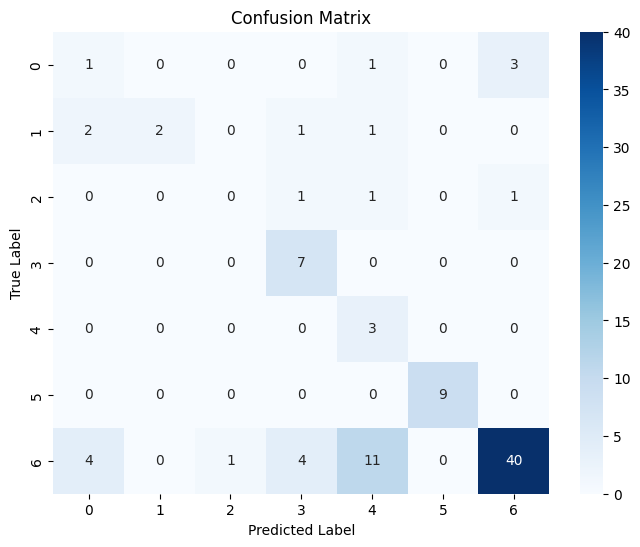

In [32]:
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300
dataset_name = 'FER_Aligned'
model_path = f'ModelsReadyForComparison/ResEmoteNet_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth'

TestResEmoteNet(data_directory, model_path, batch_size=15)

Using cuda device
Number of classes (model output): 8
Test Accuracy: 0.7473684210526316
Precision (Weighted): 0.8465660197925644
Precision (Macro): 0.632227555053642
Precision (Micro): 0.7473684210526316
Recall (Weighted): 0.7473684210526316
Recall (Macro): 0.7849206349206349
Recall (Micro): 0.7473684210526316
F1 Score (Weighted): 0.7733223661475895
F1 Score (Macro): 0.6595084750155505
F1 Score (Micro): 0.7473684210526316

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.80      0.53         5
           1       0.71      0.83      0.77         6
           2       0.27      1.00      0.43         3
           3       1.00      0.86      0.92         7
           4       0.50      1.00      0.67         3
           5       0.71      0.56      0.62         9
           6       0.96      0.73      0.83        60
           7       0.50      0.50      0.50         2

    accuracy                           0.75        95
   macr

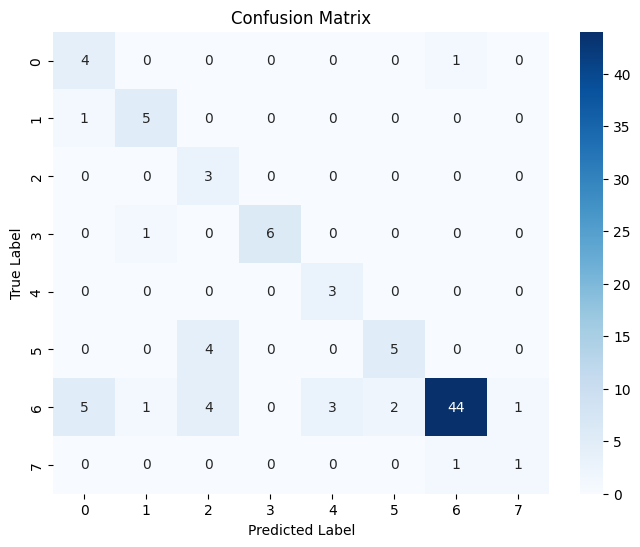

In [31]:
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300
dataset_name = 'AffectNet_Aligned'
model_path = f'ModelsReadyForComparison/ResEmoteNet_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth'

TestResEmoteNet(data_directory, model_path, batch_size=15)

Using cuda device
Number of classes (model output): 7
Test Accuracy: 0.45161290322580644
Precision (Weighted): 0.6872208436724566
Precision (Macro): 0.2598901098901099
Precision (Micro): 0.45161290322580644
Recall (Weighted): 0.45161290322580644
Recall (Macro): 0.38650793650793647
Recall (Micro): 0.45161290322580644
F1 Score (Weighted): 0.4726985979299058
F1 Score (Macro): 0.26053191302360734
F1 Score (Micro): 0.45161290322580644

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.40      0.27         5
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.35      1.00      0.52         7
           4       0.00      0.00      0.00         3
           5       0.31      0.89      0.46         9
           6       0.96      0.42      0.58        60

    accuracy                           0.45        93
   macro avg       0.26      0.39      0.26        93

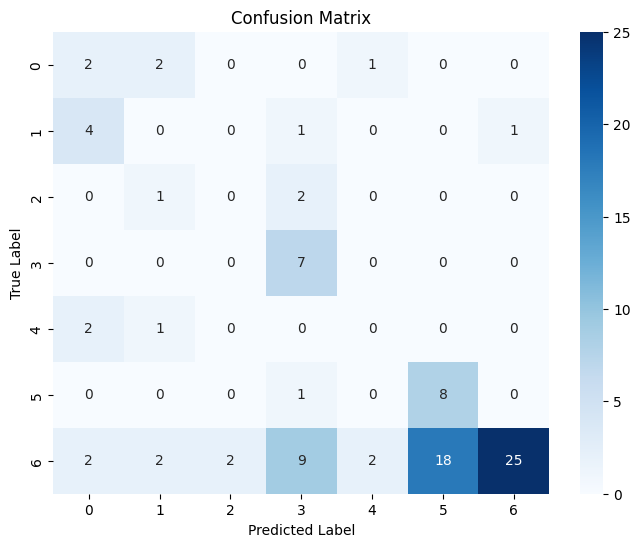

In [30]:
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300
dataset_name = 'RAF-DB_Aligned'
model_path = f'ModelsReadyForComparison/ResEmoteNet_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth'

TestResEmoteNet(data_directory, model_path, batch_size=15)